###  Module & Utility Imports

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.lines as mlines


### Load Evaluation Summary Tables from 'EvalResults/SummaryTables/' Directory


In [2]:
# Define the input directory
input_dir = './EvalResults/SummaryTables/'

# Load each summary table from CSV
AnalAccMItable = pd.read_csv(os.path.join(input_dir, 'AnalAccMItable.csv'))
SenseAccMItable = pd.read_csv(os.path.join(input_dir, 'SenseAccMItable.csv'))
BenchAnalAccMItable = pd.read_csv(os.path.join(input_dir, 'BenchAnalAccMItable.csv'))
AblaAccMItable = pd.read_csv(os.path.join(input_dir, 'AblaAccMItable.csv'))

### Generate Radar Charts for Sensitivity Analysis Metrics with Preprocessing and Styling

In [3]:
# ---------------------------
# 1. Normalization Function
# ---------------------------
def normalize_metrics(df, metric_list, group_min_max):
    """
    Normalize the specified metrics in the target DataFrame using group-specific minimum
    and maximum values computed for each group defined by ['Type', 'Source'].
    
    Parameters:
        df (DataFrame): The target DataFrame to be normalized.
        metric_list (list): A list of metric column names to be normalized.
        group_min_max (dict): A nested dictionary where keys are tuples (Type, Source)
                              and values are dictionaries of metric min/max values in the format:
                              {metric: (min, max)}.
    
    Returns:
        DataFrame: A copy of the original DataFrame with the specified metrics normalized
                   based on their group-specific min/max values.
    """
    df_norm = df.copy()
    
    # Group the DataFrame by 'Type' and 'Source'
    for group_key, group_df in df_norm.groupby(['Type', 'Source']):
        # Retrieve the min and max values for this group
        min_max = group_min_max.get(group_key, {})
        for metric in metric_list:
            if metric in min_max:
                gmin, gmax = min_max[metric]
                # Normalize the metric values for rows in this group
                if gmax > gmin:
                    df_norm.loc[group_df.index, metric] = group_df[metric].apply(lambda x: (x - gmin) / (gmax - gmin))
                else:
                    # If the maximum equals the minimum, set the normalized value to 0.0
                    df_norm.loc[group_df.index, metric] = 0.0
    return df_norm

# ---------------------------
# 2. Data Preprocessing Function
# ---------------------------
def preprocess_data(raw_df, rename_map, extra_vars, metrics_short, global_min_max):
    """
    Preprocess the raw evaluation DataFrame by renaming metric columns, grouping by
    additional variables, applying global normalization, and melting for radar chart plotting.

    Parameters:
        raw_df (DataFrame): The raw evaluation DataFrame (target dataset, e.g., SenseAccMItable).
        rename_map (dict): Mapping from original metric names to short names.
        extra_vars (list): List of extra variables (e.g., 'Depth', 'LatDim', 'Comp') to group by.
        metrics_short (list): List of metric short names.
        global_min_max (dict): A dictionary with global min and max values for each metric.
    
    Returns:
        tuple:
            data_grouped (DataFrame): The grouped and normalized DataFrame.
            df_melted (DataFrame): The melted DataFrame suitable for plotting.
    """
    data = raw_df.copy()
    data = data.rename(columns=rename_map)
    grouping_columns = ['Type', 'Source'] + extra_vars
    # Calculate group means; numeric_only=True ensures only numeric columns are averaged.
    data_grouped = data.groupby(grouping_columns).mean(numeric_only=True).reset_index()
    # Normalize the selected metric columns
    data_grouped = normalize_metrics(data_grouped, metrics_short, global_min_max)
    # Melt the DataFrame for plotting purposes
    df_melted = pd.melt(
        data_grouped,
        id_vars=['Type', 'Source'] + extra_vars,
        value_vars=metrics_short,
        var_name='Metric',
        value_name='Value'
    )
    return data_grouped, df_melted

# ---------------------------
# 3. Radar Chart Plotting Function
# ---------------------------
def plot_radar_charts(df_melted, metrics_short, metric_maps, extra_vars, ls_list, 
                      font_size=14, title_font_size=15, legend_font_size=12, 
                      wspace=0.55, hspace=0.35):
    """
    Plot radar charts for each combination of 'Type' and an extra variable (e.g., 'Depth', 'LatDim', 'Comp').
    The function creates a polar grid for each subplot, plots each source's data with distinct line styles, 
    and highlights the sector between metrics '(i)' and '(iii)'.

    Parameters:
        df_melted (DataFrame): Melted DataFrame with normalized metric values.
        metrics_short (list): List of short metric names to plot.
        metric_maps (dict): Mapping of metric short names to display labels (including directional arrows).
        extra_vars (list): List of extra variables to create subplots for.
        ls_list (list): List of line styles to differentiate sources.
        font_size (int): Font size for axis tick labels.
        title_font_size (int): Font size for subplot titles.
        legend_font_size (int): Font size for legend text.
        wspace (float): Width space between subplots.
        hspace (float): Height space between subplots.
    """
    # Determine unique types and set up the subplot grid
    types = sorted(df_melted['Type'].unique())
    n_rows = len(types)
    n_cols = len(extra_vars)
    
    fig = plt.figure(figsize=(17, 10), constrained_layout=True)
    outer = gridspec.GridSpec(n_rows, n_cols, wspace=wspace, hspace=hspace)
    
    for i, typ in enumerate(types):
        df_type = df_melted[df_melted['Type'] == typ]
        
        for j, extra in enumerate(extra_vars):
            # Subset data for the given extra variable and remove rows with missing values
            df_subset = df_type[['Source', extra, 'Metric', 'Value']].dropna(subset=[extra])
            if df_subset.empty:
                continue
            
            # Pivot the DataFrame to have metric columns for each Source and extra variable level
            pivot_df = df_subset.pivot_table(index=['Source', extra], columns='Metric', values='Value').reset_index()
            for m in metrics_short:
                if m not in pivot_df.columns:
                    pivot_df[m] = np.nan
            pivot_df = pivot_df[['Source', extra] + metrics_short]
            
            # Map each unique level of the extra variable to a distinct color
            unique_levels = sorted(df_subset[extra].unique())
            cmap = plt.get_cmap('tab10')
            extra_color_map = {
                lvl: mcolors.to_hex(cmap(idx / len(unique_levels)))
                for idx, lvl in enumerate(unique_levels)
            }
            
            # Create a polar subplot for the radar chart
            ax = fig.add_subplot(outer[i, j], projection='polar')
            num_metrics = len(metrics_short)
            angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
            angles += angles[:1]
            ax.set_ylim(0, 1.1)
            ax.tick_params(axis='y', labelsize=font_size)
            
            # Highlight the sector between metrics '(i)' and '(iii)'
            i_idx = metrics_short.index('(i)')
            iii_idx = metrics_short.index('(iii)')
            angle1 = angles[i_idx]
            angle2 = angles[iii_idx]
            if angle2 < angle1:
                angle2 += 2 * np.pi
            highlight_angles = np.concatenate([
                [angle1],
                np.linspace(angle1, angle2, 100),
                [angle2]
            ])
            highlight_radius = np.concatenate([
                [0],
                np.ones(100) * 1.1,
                [0]
            ])
            ax.fill(
                highlight_angles,
                highlight_radius,
                color='gold',
                hatch='///',
                edgecolor='orange',
                alpha=0.15,
                linewidth=0.0,
                zorder=0
            )
            
            # Plot each source's data line and fill the area under the line
            unique_sources = sorted(pivot_df['Source'].unique())
            for idx, row in pivot_df.iterrows():
                source = row['Source']
                extra_val = row[extra]
                values = [row[m] for m in metrics_short]
                values += values[:1]
                color = extra_color_map.get(extra_val, 'gray')
                ls = ls_list[unique_sources.index(source) % len(ls_list)]
                label = f"{source} ({extra}: {extra_val})"
                ax.plot(angles, values, marker='o', linestyle=ls, color=color, label=label)
                ax.fill(angles, values, color=color, alpha=0.25)
            
            # Set the axis tick labels using the metric maps for proper formatting
            ax.set_xticks(angles[:-1])
            labels = ax.set_xticklabels([metric_maps[m] for m in metrics_short], fontsize=font_size)
            for idx, (label, angle) in enumerate(zip(labels, angles[:-1])):
                angle_deg = np.degrees(angle)
                if 90 <= angle_deg <= 270:
                    label.set_horizontalalignment('right')
                else:
                    label.set_horizontalalignment('left')
                label.set_verticalalignment('center')
            
            # Set subplot title corresponding to the extra variable and add the type label to the leftmost plots
            ax.set_title(f"{extra}", fontsize=title_font_size, pad=5)
            if j == 0:
                ax.text(-0.35, 0.5, f"{typ}", transform=ax.transAxes,
                        fontsize=title_font_size + 3, fontweight='bold', va='center', ha='center')
            
            # Create a legend and assign line colors to the legend text for clarity
            leg = ax.legend(fontsize=legend_font_size, loc='upper left', bbox_to_anchor=(.65, .4))
            for text, line in zip(leg.get_texts(), ax.get_lines()):
                text.set_color(line.get_color())
                
    plt.savefig('./Figures/SensitivityAcrossParameters.png', dpi=300, bbox_inches='tight')
    plt.show()
    

### ① Visualization of Metric Sensitivity Across Model Parameters

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36192\4234211740.py:200: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('./Figures/SensitivityAcrossParameters.png', dpi=300, bbox_inches='tight')
C:\Users\lyjun\anaconda3\envs\ai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


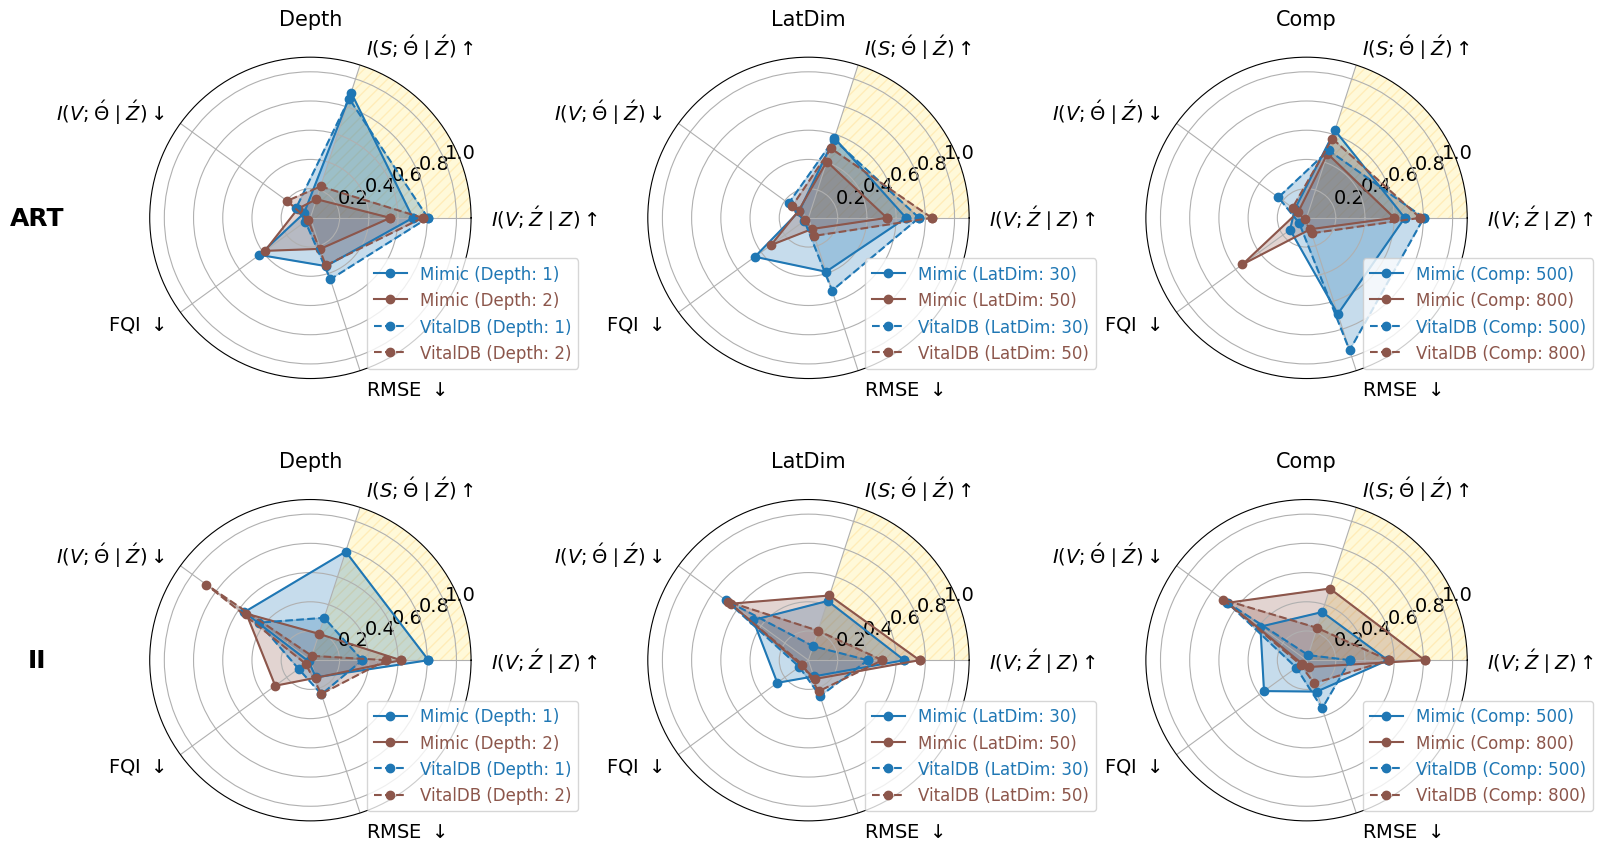

In [4]:
# Metric and Column Settings
metrics_original = [
    '(i) $I(V; \\acute{Z} \\mid Z)$',
    '(iii) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$',
    '(ii) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$',
    'FQI',
    'RMSE'
]

metric_maps = {
    '(i)': '$I(V; \\acute{Z} \\mid Z) \\uparrow$',
    '(iii)': '$I(S;\\acute{\\Theta} \\mid \\acute{Z}) \\uparrow$',
    '(ii)': '$I(V;\\acute{\\Theta} \\mid \\acute{Z}) \\downarrow$',
    'FQI': 'FQI $\\downarrow$',
    'RMSE': 'RMSE $\\downarrow$'
}

extra_vars = ['Depth', 'LatDim', 'Comp']
metrics_short = ['(i)', '(iii)', '(ii)', 'FQI', 'RMSE']


# Define style parameters for the radar chart
FONT_SIZE = 14
TITLE_FONT_SIZE = 15
LEGEND_FONT_SIZE = 12
WSPACE = 0.55
HSPACE = 0.35
ls_list = ['-', '--', '-.', ':']


# Mapping from original metric names to short names.
rename_map = dict(zip(metrics_original, metrics_short))

# Apply the renaming so that each DataFrame has columns with the short names.
AnalAccMItable_renamed = AnalAccMItable.rename(columns=rename_map)
SenseAccMItable_renamed = SenseAccMItable.rename(columns=rename_map)
BenchAnalAccMItable_renamed = BenchAnalAccMItable.rename(columns=rename_map)
AblaAccMItable_renamed = AblaAccMItable.rename(columns=rename_map)

# Combine all four DataFrames. Now each one should have the columns as in metrics_short.
all_dfs = pd.concat([
    AnalAccMItable_renamed,
    SenseAccMItable_renamed,
    #BenchAnalAccMItable_renamed,
    AblaAccMItable_renamed])


# Compute Global Minimum and Maximum ---
group_min_max = {}
for group_key, group_data in all_dfs.groupby(['Type', 'Source']):
    # group_key is a tuple of (Type, Source)
    group_min_max[group_key] = {}
    for metric in metrics_short:
        gmin = group_data[metric].min()
        gmax = group_data[metric].max()
        group_min_max[group_key][metric] = (gmin, gmax)

# Preprocess the data: rename metrics, group by parameters, and normalize.
data_grouped, df_melted = preprocess_data(SenseAccMItable, rename_map, extra_vars, metrics_short, group_min_max)

# Generate the radar charts using the preprocessed melted DataFrame
plot_radar_charts(
    df_melted,
    metrics_short,
    metric_maps,
    extra_vars,
    ls_list,
    font_size=FONT_SIZE,
    title_font_size=TITLE_FONT_SIZE,
    legend_font_size=LEGEND_FONT_SIZE,
    wspace=WSPACE,
    hspace=HSPACE)

### Generate Radar Charts for Ablation Study Metrics with Preprocessing and Styling

In [5]:
# -----------------------------------------------------------------------------
# 1. Helper Function to Shorten Ablation Model Names for the Legend
# -----------------------------------------------------------------------------
def shorten_ablation_model_name(model_name):
    """
    Simplifies the ablation model name by returning the first segment before '_'.
    Assumes model names follow a structured format like 'SKZFC_ART_1_50_800'.

    Parameters:
        model_name (str): Full ablation model name.

    Returns:
        str: Simplified label (e.g., 'SKZFC').
    """
    return model_name.split("_")[0]

# -----------------------------------------------------------------------------
# 2. Radar Chart Plotting Functions
# -----------------------------------------------------------------------------
def plot_radar_subplot(ax, data, metrics, main_models, main_color):
    """
    Draws a radar chart on the provided polar Axes for the given (Type, Source) subset.
    
    Main models are drawn with a unified solid line (main_color), and ablation models
    are drawn with dotted lines using distinct colors drawn from a custom palette.
    
    Additionally, the function highlights the sector between metrics '(i)' and '(iii)'.
    The x-axis tick labels are set via metric_maps and aligned based on the angle.
    
    Parameters:
        ax (Axes): The matplotlib polar Axes on which to plot.
        data (DataFrame): Evaluation data for one (Type, Source) combination.
        metrics (list): List of final display metric names (the x-axis tick labels).
        main_models (list): List of model names considered main.
        main_color (str): The unified color for all main models.
    """
    # Compute angles based on the number of metrics (assuming the same order as metrics_short)
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the radar loop

    # Set radial limits and tick label size
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='y', labelsize=FONT_SIZE)
    
    # -------------------------
    # Highlight Sector Feature
    # -------------------------
    # Highlight the sector between metrics '(i)' and '(iii)'
    i_idx = metrics_short.index('(i)')
    iii_idx = metrics_short.index('(iii)')
    angle1 = angles[i_idx]
    angle2 = angles[iii_idx]
    if angle2 < angle1:
        angle2 += 2 * np.pi
    highlight_angles = np.concatenate([
        [angle1],
        np.linspace(angle1, angle2, 100),
        [angle2]
    ])
    highlight_radius = np.concatenate([
        [0],
        np.ones(100) * 1.1,
        [0]
    ])
    ax.fill(
        highlight_angles,
        highlight_radius,
        color='gold',
        hatch='///',
        edgecolor='orange',
        alpha=0.15,
        linewidth=0.0,
        zorder=0
    )
    
    # ------------------------------------
    # Plot model lines and fill the areas.
    # ------------------------------------
    # Identify ablation models (not in main_models)
    ablation_models = data[~data['Model'].isin(main_models)]['Model'].unique()
    # Use a palette of distinct (non-gray) colors for ablation models.
    ablation_color_list = ablation_color_list = ['brown', 'darkgreen', 'purple', 'teal', 'goldenrod', 'cornflowerblue', 'indigo', 'darkorange', 'slateblue']
    ablation_color_mapping = {model: ablation_color_list[i % len(ablation_color_list)]
                              for i, model in enumerate(ablation_models)}
    
    plotted_labels = set()
    
    for _, row in data.iterrows():
        model_name = row['Model']
        # Get values in the order of final display metric names
        values = [row[m] for m in metrics]
        values += values[:1]  # Close the polygon
        
        if model_name in main_models:
            color = main_color
            linestyle = '-'    # Solid line for main models
            alpha_fill = 0.25
            marker = 'D' 
            label = "Main"
        else:
            color = ablation_color_mapping.get(model_name, 'black')
            linestyle = ':'    # Dotted line for ablation models
            alpha_fill = 0.1
            marker = 'o' 
            # Shorten the legend label to high-level (e.g., FC, SKZ) for ablation models.
            label = shorten_ablation_model_name(model_name)
        
        # Avoid duplicate legend entries for the same label.
        if label in plotted_labels:
            line_label = '_nolegend_'
        else:
            line_label = label
            plotted_labels.add(label)
        
        ax.plot(angles, values, color=color, marker=marker, linestyle=linestyle, label=line_label)
        ax.fill(angles, values, color=color, alpha=alpha_fill)
    
    # Set the axis tick labels using metric_maps for proper formatting.
    ax.set_xticks(angles[:-1])
    labels = ax.set_xticklabels([metric_maps[m] for m in metrics_short], fontsize=FONT_SIZE)
    ax.tick_params(axis='x', pad=TICK_LABEL_PAD)
    
    # Adjust label alignment based on the angle.
    for label, angle in zip(labels, angles[:-1]):
        angle_deg = np.degrees(angle)
        if 90 <= angle_deg <= 270:
            label.set_horizontalalignment('right')
        else:
            label.set_horizontalalignment('left')
        label.set_verticalalignment('center')
    
    ax.tick_params(axis='y', labelsize=FONT_SIZE)

def plot_radar_grid(evaluation_df, metrics, main_models, main_color, figname, legend_ncol=1):
    """
    Creates a grid of radar charts arranged in a 1-row x 4-columns layout—one subplot per
    (Type, Source) combination from the evaluation DataFrame.
    
    Parameters:
        evaluation_df (DataFrame): Evaluation table containing 'Model', 'Type', 'Source'
                                   and the metric columns.
        metrics (list): List of final display metric names for the x-axis tick labels.
        main_models (list): List of model names considered main.
        main_color (str): Unified color for all main models.
        legend_ncol (int): Number of columns for the legend.
    """
    # Get unique (Type, Source) combinations and select the first 4 groups.
    unique_groups = evaluation_df[['Type', 'Source']].drop_duplicates().values.tolist()
    groups = unique_groups[:4]
    n_cols = len(groups)
    
    fig, axes = plt.subplots(1, n_cols, subplot_kw=dict(projection='polar'),
                             figsize=(n_cols * 6, 5))
    if n_cols == 1:
        axes = [axes]
    
    for i, (typ, src) in enumerate(groups):
        ax = axes[i]
        subset = evaluation_df[(evaluation_df['Type'] == typ) & (evaluation_df['Source'] == src)]
        if subset.empty:
            ax.set_visible(False)
            continue
        plot_radar_subplot(ax, subset, metrics, main_models, main_color)
        ax.set_title(f"{typ} & {src}", fontsize=TITLE_FONT_SIZE, pad=10)
        ax.legend(fontsize=LEGEND_FONT_SIZE, loc='upper left', bbox_to_anchor=(.65, .4), ncol=legend_ncol, columnspacing=0.5)
    
    plt.tight_layout(w_pad=WSPACE, h_pad=HSPACE)
    plt.savefig('./Figures/'+ figname +'.png', dpi=300, bbox_inches='tight')
    plt.show()




### ② Visualization of Metric Sensitivity Across Ablation Models

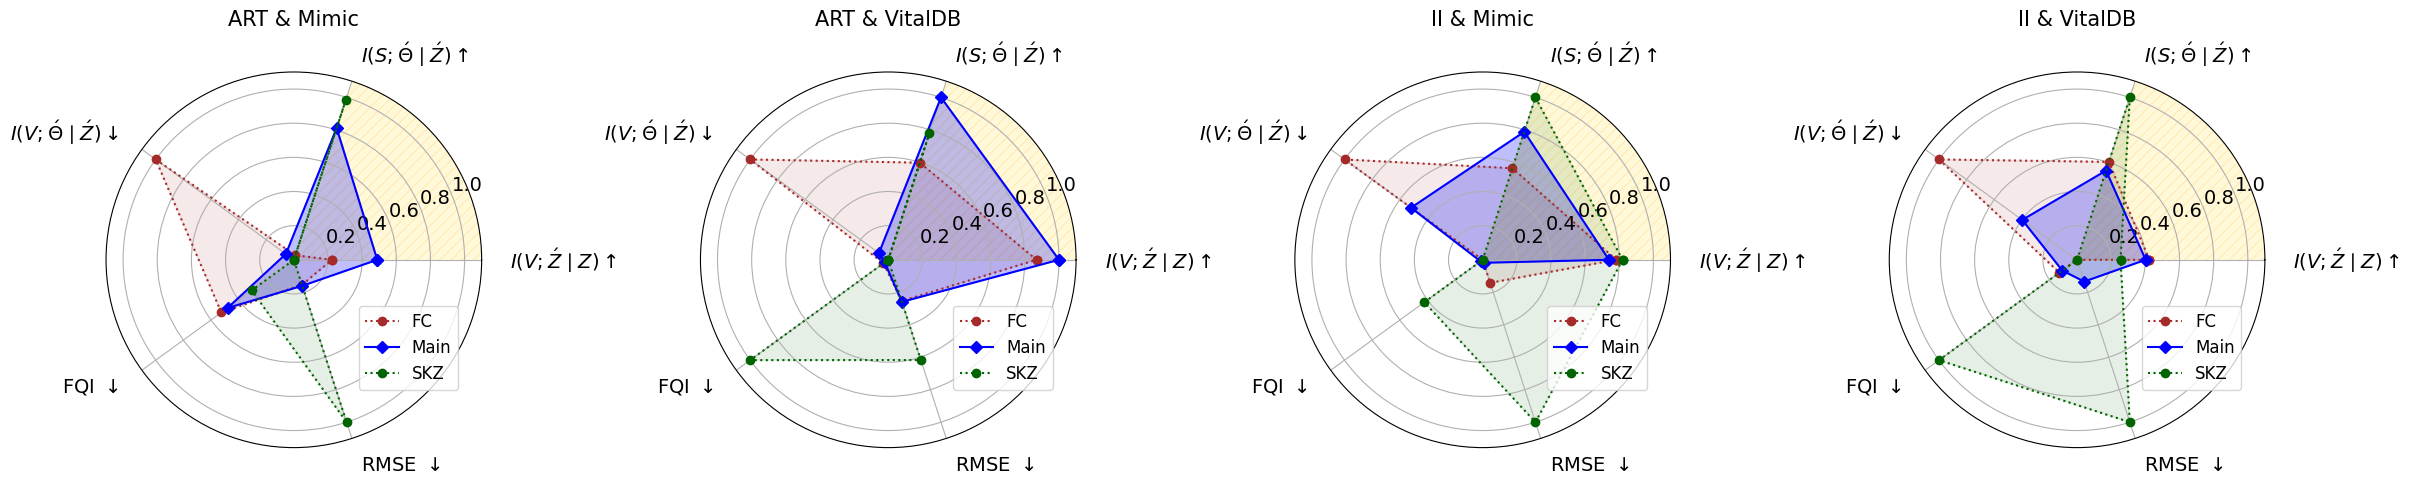

In [6]:
# Metric and Column Settings
FONT_SIZE = 14             # Font size for tick labels (metric labels on the radar)
TITLE_FONT_SIZE = 15       # Font size for subplot titles
LEGEND_FONT_SIZE = 12      # Font size for legend entries
WSPACE = 0.55              # Horizontal space between subplots
HSPACE = 0.35              # Vertical space between subplots
TICK_LABEL_PAD = 10        # Padding for the metric labels from the radar chart
main_color = 'blue'       # Unified color for all main models

# List of main model names (these will be drawn using a unified color)
main_models = [
    'SKZFC_ART_1_50_800_Mimic',
    'SKZFC_ART_1_50_800_VitalDB',
    'SKZFC_II_1_50_800_Mimic',
    'SKZFC_II_1_50_800_VitalDB'
]

# Original metric names and short names
metrics_original = [
    '(i) $I(V; \\acute{Z} \\mid Z)$',
    '(iii) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$',
    '(ii) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$',
    'FQI',
    'RMSE'
]
metrics_short = ['(i)', '(iii)', '(ii)', 'FQI', 'RMSE']

# Mapping from original names to short names.
rename_map = dict(zip(metrics_original, metrics_short))

# Final display names for plotting (used for the x-axis tick labels)
metric_maps = {
    '(i)': '$I(V; \\acute{Z} \\mid Z) \\uparrow$',
    '(iii)': '$I(S;\\acute{\\Theta} \\mid \\acute{Z}) \\uparrow$',
    '(ii)': '$I(V;\\acute{\\Theta} \\mid \\acute{Z}) \\downarrow$',
    'FQI': 'FQI $\\downarrow$',
    'RMSE': 'RMSE $\\downarrow$'
}


# Mapping from original metric names to short names.
rename_map = dict(zip(metrics_original, metrics_short))

# Apply the renaming so that each DataFrame has columns with the short names.
AnalAccMItable_renamed = AnalAccMItable.rename(columns=rename_map)
SenseAccMItable_renamed = SenseAccMItable.rename(columns=rename_map)
BenchAnalAccMItable_renamed = BenchAnalAccMItable.rename(columns=rename_map)
AblaAccMItable_renamed = AblaAccMItable.rename(columns=rename_map)

# Combine all four DataFrames. Now each one should have the columns as in metrics_short.
all_dfs = pd.concat([
    AnalAccMItable_renamed,
    SenseAccMItable_renamed,
    #BenchAnalAccMItable_renamed,
    AblaAccMItable_renamed])


# Compute Global Minimum and Maximum ---
group_min_max = {}
for group_key, group_data in all_dfs.groupby(['Type', 'Source']):
    # group_key is a tuple of (Type, Source)
    group_min_max[group_key] = {}
    for metric in metrics_short:
        gmin = group_data[metric].min()
        gmax = group_data[metric].max()
        group_min_max[group_key][metric] = (gmin, gmax)
        


# Normalize the metrics using your group-specific normalization function
data = AblaAccMItable.copy()
data = data.rename(columns=rename_map)
data = normalize_metrics(data, metrics_short, group_min_max)
data = data.rename(columns=metric_maps)

# Prepare the list of final display metric names (for plotting in the radar chart)
radar_metrics = list(metric_maps.values())


# Plot the Radar Grid (1 row x 4 columns layout)
plot_radar_grid(data, radar_metrics, main_models, main_color, figname='SensitivityAcrossAblation')


### ③ Visualization of Metric Sensitivity Across Main and Benchmark Models

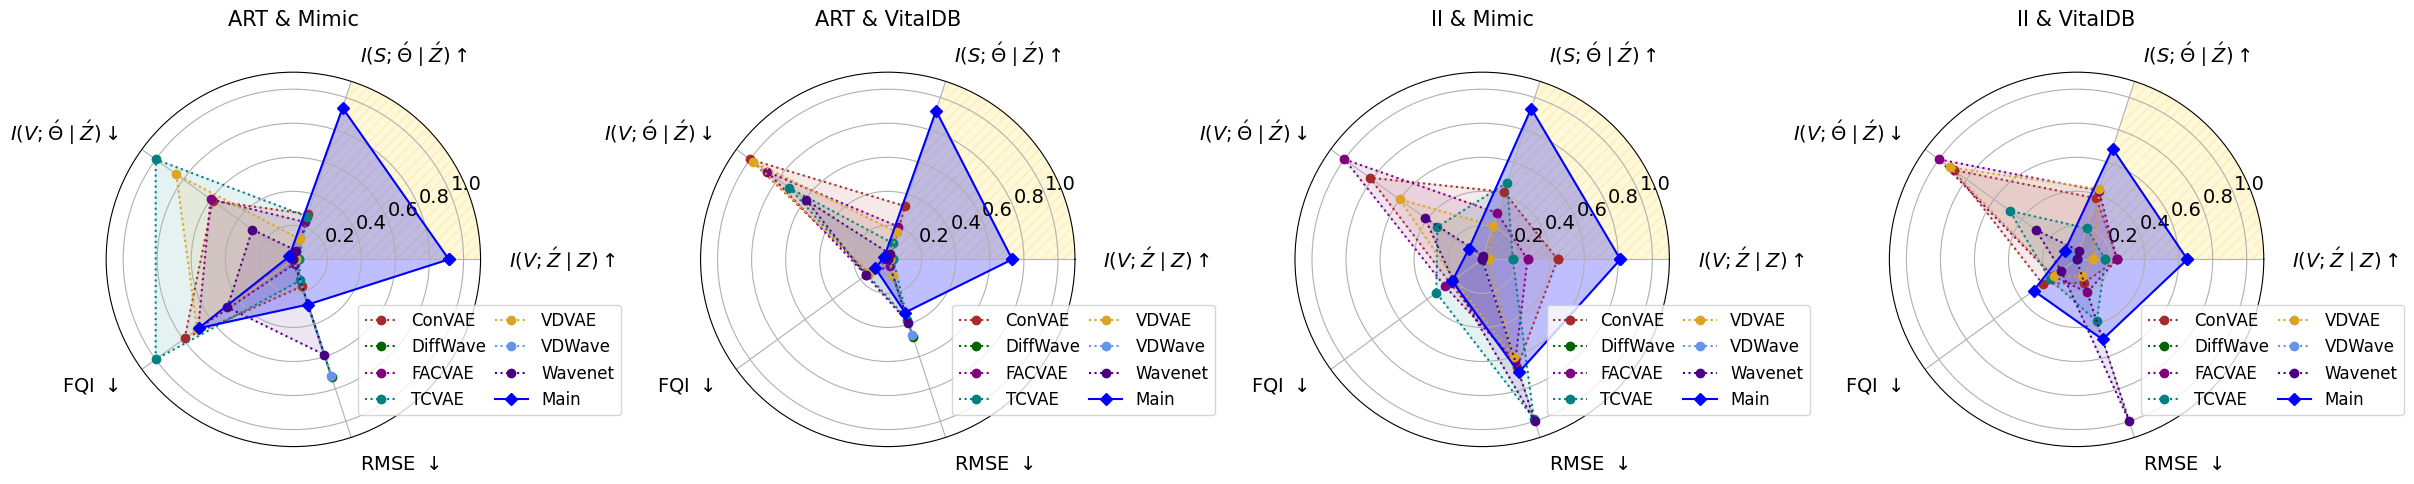

In [7]:
main_models = [
    'SKZFC_ART_1_30_800_Mimic',
    'SKZFC_ART_1_30_800_VitalDB',
    'SKZFC_II_1_30_800_Mimic',
    'SKZFC_II_1_30_800_VitalDB'
]

# Mapping from original metric names to short names.
rename_map = dict(zip(metrics_original, metrics_short))

# Apply the renaming so that each DataFrame has columns with the short names.
AnalAccMItable_renamed = AnalAccMItable.rename(columns=rename_map)
SenseAccMItable_renamed = SenseAccMItable.rename(columns=rename_map)
BenchAnalAccMItable_renamed = BenchAnalAccMItable.rename(columns=rename_map)
AblaAccMItable_renamed = AblaAccMItable.rename(columns=rename_map)

# Combine all four DataFrames. Now each one should have the columns as in metrics_short.
all_dfs = pd.concat([
    AnalAccMItable_renamed,
    SenseAccMItable_renamed,
    BenchAnalAccMItable_renamed,
    AblaAccMItable_renamed])


# Compute Global Minimum and Maximum ---
group_min_max = {}
for group_key, group_data in all_dfs.groupby(['Type', 'Source']):
    # group_key is a tuple of (Type, Source)
    group_min_max[group_key] = {}
    for metric in metrics_short:
        gmin = group_data[metric].min()
        gmax = group_data[metric].max()
        group_min_max[group_key][metric] = (gmin, gmax)
        


# Normalize the metrics using your group-specific normalization function
data = BenchAnalAccMItable.copy()
data = data.rename(columns=rename_map)
data = normalize_metrics(data, metrics_short, group_min_max)
data = data.rename(columns=metric_maps)

# Prepare the list of final display metric names (for plotting in the radar chart  )
radar_metrics = list(metric_maps.values())

# Plot the Radar Grid (1 row x 4 columns layout)
plot_radar_grid(data, radar_metrics, main_models, main_color, figname='SensitivityAcrossBenchmarks', legend_ncol=2)

### Model Performance by Iscore vs. RMSE

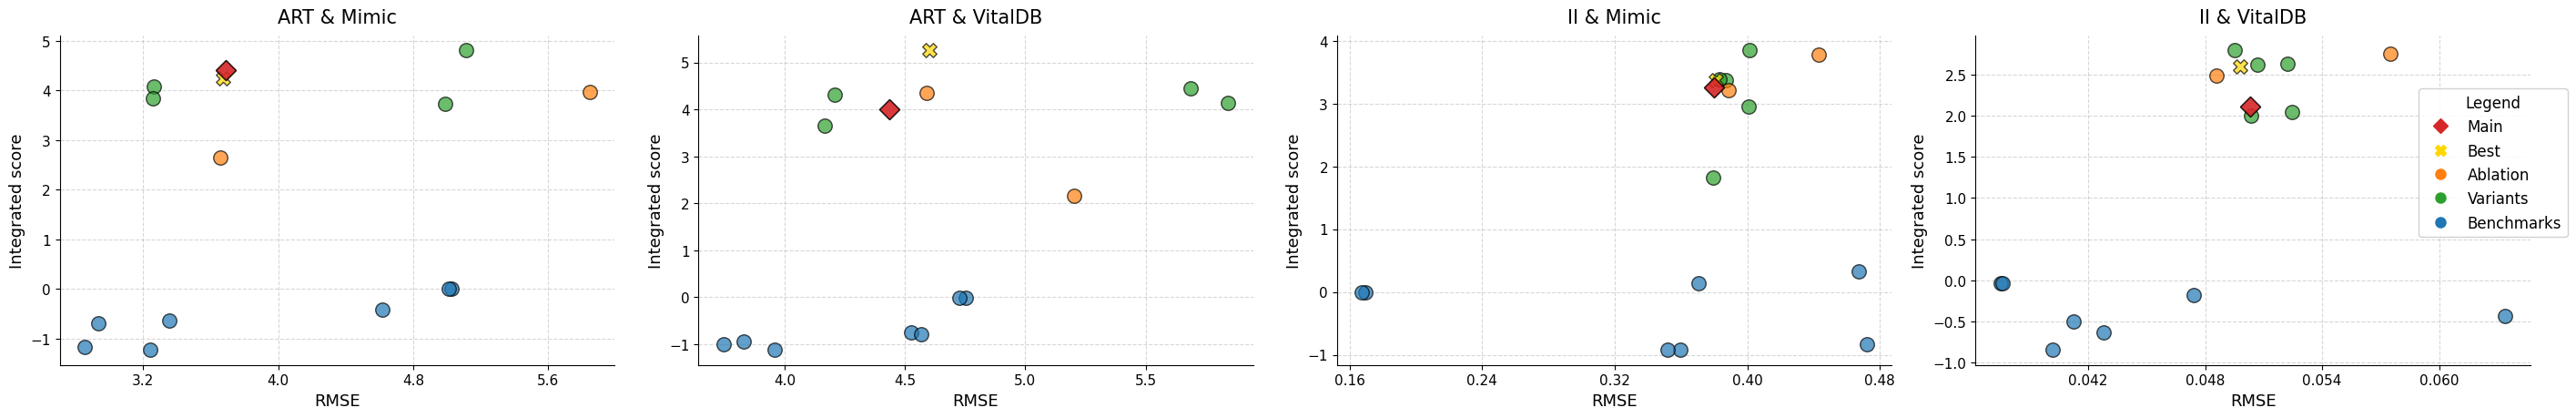

In [8]:
# 
main_models = [
    'SKZFC_ART_1_30_800_Mimic',
    'SKZFC_ART_1_30_800_VitalDB',
    'SKZFC_II_1_30_800_Mimic',
    'SKZFC_II_1_30_800_VitalDB'
]

best_models = [
    'SKZFC_ART_1_50_800_Mimic',
    'SKZFC_ART_1_50_800_VitalDB',
    'SKZFC_II_1_50_800_Mimic',
    'SKZFC_II_1_50_800_VitalDB'
]

SenseAccMItable['Category'] = 'Variants'
BenchAnalAccMItable['Category'] = 'Benchmarks'
AblaAccMItable['Category'] = 'Ablation'

Cols = ['Source','Type', 'Category','Model','RMSE','ISCORE']

AllModels = pd.concat([ SenseAccMItable[~SenseAccMItable['Model'].isin(best_models)][Cols], BenchAnalAccMItable[~BenchAnalAccMItable['Model'].isin(best_models)][Cols], AblaAccMItable[Cols]]).reset_index(drop=True)
AllModels = AllModels.drop_duplicates().reset_index(drop=True)
AllModels.loc[AllModels['Model'].isin(main_models), 'Category'] ='Main'
AllModels.loc[AllModels['Model'].isin(best_models), 'Category'] ='Best'


# -----------------------------------------------------------------------------
# Global Style and Layout Settings
# -----------------------------------------------------------------------------
FONT_SIZE = 14             # Font size for axis tick labels
TITLE_FONT_SIZE = 15       # Font size for subplot titles
LEGEND_FONT_SIZE = 12      # Font size for legend text
WSPACE = 0.55              # Horizontal spacing between subplots
HSPACE = 0.35              # Vertical spacing between subplots
TICK_LABEL_PAD = 10        # Padding for axis tick labels

# -----------------------------------------------------------------------------
# Define Category Color Mapping
# -----------------------------------------------------------------------------
# IMPORTANT: Ensure the 'Category' column in AllModels exactly matches these keys.
category_colors = {
    'Ablation': 'tab:orange',  
    'Variants': 'tab:green',  
    'Benchmarks': 'tab:blue', 
    'Best': 'gold',        # Changed here
    'Main': 'tab:red'      
}

# -----------------------------------------------------------------------------
# Define Category Marker Mapping
# -----------------------------------------------------------------------------
# Use the same marker for all sources, but different marker for Main
DEFAULT_MARKER = 'o'       # Default marker for all categories except Main
MAIN_MARKER = 'D'          # Diamond marker for Main category
BEST_MARKER = 'X'          # Diamond marker for Main category

# -----------------------------------------------------------------------------
# Create a 1x4 Grid of Subplots by (Type, Source)
# -----------------------------------------------------------------------------
# It is assumed that AllModels is a DataFrame that includes:
# 'RMSE', 'ISCORE', 'Category', 'Type', and 'Source'.
# We extract the unique (Type, Source) combinations.
unique_combinations = AllModels[['Type', 'Source']].drop_duplicates()
# Sort combinations by Type then Source for consistency.
combinations = unique_combinations.sort_values(by=['Type', 'Source']).values.tolist()

# Create a 1-row x N-columns subplot grid.
fig, axes = plt.subplots(1, len(combinations), figsize=(7 * len(combinations), 5))
if len(combinations) == 1:  # Ensure axes is always an iterable.
    axes = [axes]

# -----------------------------------------------------------------------------
# Plot Scatter for Each (Type, Source) Combination
# -----------------------------------------------------------------------------
# For each subplot, filter the data by Type and Source. In each subset:
# - Marker shape is only different for Main category.
# - Color is defined by Category (using category_colors).

for ax, (t, s) in zip(axes, combinations):
    # Filter the data for the current Type and Source.
    subset = AllModels[(AllModels['Type'] == t) & (AllModels['Source'] == s)]
    
    # Define plotting order to ensure 'Main' is plotted last (on top)
    # Sort categories so 'Main' comes last
    ordered_categories = sorted(subset['Category'].unique(), key=lambda x: 1 if x == 'Main' else 0)
    
    # Plot points for each Category within this subset in the specified order.
    for category in ordered_categories:
        group = subset[subset['Category'] == category]
        color = category_colors.get(category, 'gray')
        
        # Use special marker for Main category, otherwise use default marker
        if category == 'Main':
            marker_to_use = MAIN_MARKER
        elif category == 'Best':
            marker_to_use = BEST_MARKER
        else:
            marker_to_use = DEFAULT_MARKER

        ax.scatter(
            group['RMSE'], group['ISCORE'],
            color=color,
            marker=marker_to_use,
            s=125, alpha=0.7, edgecolors='black',
            label=category,  # Legend label will be handled in the shared legend
            zorder=10 if category == 'Main' else 5  # Higher zorder for Main to ensure it's on top
        )
    
    # Configure subplot title and axis labels.
    ax.set_title(f"{t} & {s}", fontsize=TITLE_FONT_SIZE, pad=10)
    ax.set_xlabel('RMSE', fontsize=13)
    ax.set_ylabel('Integrated score', fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.5)
    # Remove top and right spines for a cleaner, publication-style look.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=11)
    
    # -----------------------------------------------------------------------------
    # Local x-axis scaling for each subplot
    # -----------------------------------------------------------------------------
    if len(subset) > 0:
        # Get RMSE values for this subplot only
        rmse_values = subset['RMSE'].values
        
        # Calculate min and max with 5% padding
        rmse_min = np.min(rmse_values)
        rmse_max = np.max(rmse_values)
        padding = (rmse_max - rmse_min) * 0.05  # 5% padding
        
        # Set x limits for this subplot with padding
        ax.set_xlim(rmse_min - padding, rmse_max + padding)
        
        # Auto-adjust tick locations for better readability
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Limit to ~5 ticks for readability

# -----------------------------------------------------------------------------
# Create a Legend for Category Only (Removing Source Information)
# -----------------------------------------------------------------------------
# Custom handles for Category (colors and markers) are defined.
# Make sure the legend order follows a consistent order, with Main appearing first
ordered_categories = ['Main', 'Best', 'Ablation', 'Variants', 'Benchmarks']
cat_handles = []
for cat in ordered_categories:
    if cat in category_colors:
        # Use special marker for Main in the legend
        if cat == 'Main':
            marker_to_use = MAIN_MARKER
        elif cat == 'Best':
            marker_to_use = BEST_MARKER
        else:
            marker_to_use = DEFAULT_MARKER
        cat_handles.append(
            mlines.Line2D([], [], color=category_colors.get(cat), marker=marker_to_use, 
                          linestyle='None', markersize=8, label=cat)
        )

# Place the legend at the top center of the figure.
fig.legend(
    cat_handles, [h.get_label() for h in cat_handles],
    title='Legend',
    title_fontsize=LEGEND_FONT_SIZE,
    fontsize=LEGEND_FONT_SIZE,
    loc='upper center',
    bbox_to_anchor=(0.98, 0.75),  # Position legend precisely
    ncol=1,  # Display all items in a single row
    columnspacing=1.0,
    frameon=True,
    framealpha=0.9,
    fancybox=True
)

# -----------------------------------------------------------------------------
# Final Layout Adjustments and Display
# -----------------------------------------------------------------------------
plt.tight_layout()
# Adjust layout to make room for the shared legend.
plt.subplots_adjust(top=0.85)

plt.savefig('./Figures/IScoreRMSE.png', dpi=300, bbox_inches='tight')
plt.show()